In [1]:
import numpy as np
import pandas as pd
from chromatography import *
from separation_utility import *
from torch import optim, tensor
import torch.nn as nn
import matplotlib.pyplot as plt
import time

In [ ]:
alists = []
alists.append(pd.read_csv('../data/GilarSample.csv'))
alists.append(pd.read_csv('../data/Alizarin.csv'))
alists.append(pd.read_csv('../data/Peterpeptides.csv'))
alists.append(pd.read_csv('../data/Roca.csv'))
alists.append(pd.read_csv('../data/Peter32.csv'))
alists.append(pd.read_csv('../data/Eosin.csv'))
alists.append(pd.read_csv('../data/Controlmix2.csv'))
alists.append(pd.read_csv('../data/Gooding.csv'))
# GilarSample - 8 analytes
# Peterpeptides - 32 analytes
# Roca - 14 analytes
# Peter32 - 32 analytes
# Eosin - 20 analytes
# Alizarin - 16 analytes
# Controlmix2 - 17 analytes
# Gooding - 872 analytes

In [2]:
def loss_field(exp, taus, N = 200):
    phis = np.linspace(0, 1, N)
    losses = np.zeros((N, N))
    j = 0
    for phi1 in phis:
        i = 0
        for phi2 in phis:
            exp.reset()
            exp.run_all([phi1, phi2], taus)
            losses[i, j] = exp.loss()
            i += 1
        j += 1
    X, Y = np.meshgrid(phis, phis)
    
    return X, Y, losses

def average_over_equal_intervals(arr, interval):
    return np.mean(arr.reshape(-1, interval), axis=1)

### Experiment: Performance vs n_steps

In [ ]:
# Parameters
all_analytes = pd.concat(alists, sort=True).reset_index()[['k0', 'S', 'lnk0']]

kwargs = {
    'num_episodes' : 25_000, 
    'sample_size' : 10,
    'batch_size' : 1, 
    'lr' : .05, 
    'optim' : torch.optim.SGD,
    'lr_decay_factor' : 0.75,
    'lr_milestones' : 5000,
    'print_every' : 25_001,
    'baseline' : .55,
    'max_norm' : 1.5,
    'max_rand_analytes' : 40,
    'min_rand_analytes' : 8,
    'rand_prob' : 1.,
    'h' : 0.001,
    'run_time' : 1.
}
N = 7
M = 15

losses_50_50 = np.zeros((N, M, kwargs['num_episodes']))
test_losses_50_50 = np.zeros((N, M, kwargs['num_episodes']))
losses_100 = np.zeros((N, M, kwargs['num_episodes']))

for n in range(0, N):
    print(n)
    delta_taus = np.ones(n + 1) * 1/(n + 1)
    
    for i in range(M):
        alist_train = all_analytes.sample(frac=0.5)
        alist_test = all_analytes.loc[lambda a: ~a.index.isin(alist_train.index.values)]
        print(f"  {i}")
        #Policies
        pol_50_50 = PolicyGeneral(
            phi = nn.Sequential(
                PermEqui2_max(2, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
            ),
            rho = nn.Sequential(
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                Rho(n_steps=len(delta_taus), hidden=5, in_dim=5, sigma_max=.3, sigma_min=.01),
            )
        )
        pol_100 = PolicyGeneral(
            phi = nn.Sequential(
                PermEqui2_max(2, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
            ),
            rho = nn.Sequential(
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                Rho(n_steps=len(delta_taus), hidden=5, in_dim=5, sigma_max=.3, sigma_min=.01),
            )
        )
        # Run Exp
        loss, loss_test = reinforce_gen(
            alists = [alist_train], 
            test_alist = alist_test,
            policy = pol_50_50, 
            delta_taus = delta_taus, 
            **kwargs
        )
        loss_100, _ = reinforce_gen(
            alists = [all_analytes], 
            test_alist = None,
            policy = pol_100, 
            delta_taus = delta_taus, 
            **kwargs
        )
        
        losses_50_50[n,i] = loss
        test_losses_50_50[n,i] = loss_test
        losses_100[n,i] = loss_100


In [ ]:
#np.savez_compressed("../results/general_perf_vs_n_steps", losses_50_50=losses_50_50, test_losses_50_50=test_losses_50_50, losses_100=losses_100)
np.savez_compressed("../results/general_perf_vs_n_steps_losses_50", losses_50_50=losses_50_50)
np.savez_compressed("../results/general_perf_vs_n_steps_test_losses_50_50", test_losses_50_50=test_losses_50_50)
np.savez_compressed("../results/general_perf_vs_n_steps_losses_100", losses_100=losses_100)

### Performance vs number of analytes

In [ ]:
# Parameters
all_analytes = pd.concat(alists, sort=True).reset_index()[['k0', 'S', 'lnk0']]

kwargs = {
    'num_episodes' : 25_000, 
    'sample_size' : 10,
    'batch_size' : 1, 
    'lr' : .05, 
    'optim' : torch.optim.SGD,
    'lr_decay_factor' : 0.75,
    'lr_milestones' : 5000,
    'print_every' : 25_001,
    'baseline' : .55,
    'max_norm' : 1.5,
    'rand_prob' : 1.,
    'h' : 0.001,
    'run_time' : 1.
}
N = 5
M = 30

losses_50_50 = np.zeros((N, M, kwargs['num_episodes']))
test_losses_50_50 = np.zeros((N, M, kwargs['num_episodes']))
losses_100 = np.zeros((N, M, kwargs['num_episodes']))


delta_taus = np.ones(10) * 1/(10)
for n in range(N):
    for i in range(M):
        alist_train = all_analytes.sample(frac=0.5)
        alist_test = all_analytes.loc[lambda a: ~a.index.isin(alist_train.index.values)]
        print(f"  {i}")
        #Policies
        pol_50_50 = PolicyGeneral(
            phi = nn.Sequential(
                PermEqui2_max(2, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
            ),
            rho = nn.Sequential(
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                Rho(n_steps=len(delta_taus), hidden=5, in_dim=5, sigma_max=.3, sigma_min=.01),
            )
        )
        pol_100 = PolicyGeneral(
            phi = nn.Sequential(
                PermEqui2_max(2, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
                PermEqui2_max(5, 5),
                nn.ELU(inplace=True),
            ),
            rho = nn.Sequential(
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                nn.Linear(5, 5),
                nn.ELU(inplace=True),
                Rho(n_steps=len(delta_taus), hidden=5, in_dim=5, sigma_max=.3, sigma_min=.01),
            )
        )
        # Run Exp
        loss, loss_test = reinforce_gen(
            alists = [alist_train], 
            test_alist = alist_test,
            policy = pol_50_50, 
            delta_taus = delta_taus,
            min_rand_analytes = 8 * (n + 1),
            max_rand_analytes = 8 * (n + 1),
            **kwargs
        )
        loss_100, _ = reinforce_gen(
            alists = [all_analytes], 
            test_alist = None,
            policy = pol_100, 
            delta_taus = delta_taus,
            min_rand_analytes = 8 * (n + 1),
            max_rand_analytes = 8 * (n + 1),
            **kwargs
        )

        losses_50_50[n,i] = loss
        test_losses_50_50[n,i] = loss_test
        losses_100[n,i] = loss_100


In [ ]:
np.savez_compressed("../results/general_perf_vs_nr_analytes_losses_50", losses_50_50=losses_50_50)
np.savez_compressed("../results/general_perf_vs_nr_analytes_test_losses_50_50", test_losses_50_50=test_losses_50_50)
np.savez_compressed("../results/general_perf_vs_nr_analytes_losses_100", losses_100=losses_100)

In [3]:
losses_50_50 = np.load('../results/general_perf_vs_n_steps_losses_50.npz')['losses_50_50']
test_losses_50_50 = np.load('../results/general_perf_vs_n_steps_test_losses_50_50.npz')['test_losses_50_50']
losses_100 = np.load('../results/general_perf_vs_n_steps_losses_100.npz')['losses_100']

In [4]:
data_100  = []
for i in range(10):
    data_100.append([])
    for j in range(20):
        data_100[i].append(average_over_equal_intervals(losses_100[i,j], 500))
data_100 = np.array(data_100)

data_50_50  = []
for i in range(10):
    data_50_50.append([])
    for j in range(20):
        data_50_50[i].append(average_over_equal_intervals(losses_50_50[i,j], 500))
data_50_50 = np.array(data_50_50)

data_50_50_t  = []
for i in range(10):
    data_50_50_t.append([])
    for j in range(20):
        data_50_50_t[i].append(average_over_equal_intervals(test_losses_50_50[i,j], 500))
data_50_50_t = np.array(data_50_50_t)

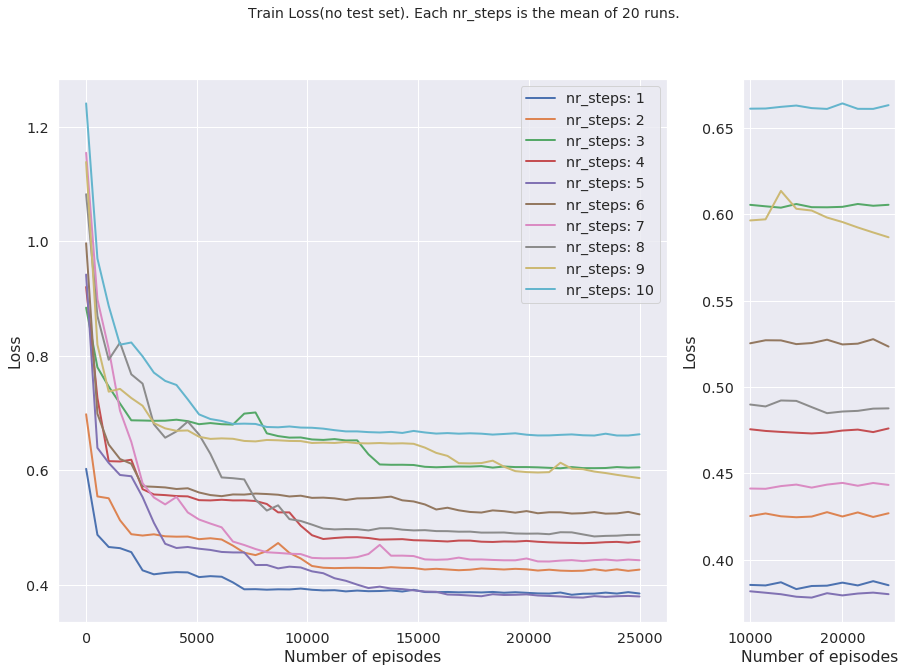

In [22]:
from matplotlib import gridspec
import seaborn as sns
sns.set(style="whitegrid")
sns.set(font_scale=1.3)
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 

func = np.mean
D = data_100

plt.subplot(gs[0])
plt.rcParams['figure.figsize'] = (15, 10)
for i in range(10):

    plt.plot(np.linspace(0, 25000, 50),func(D, 1)[i], label="nr_steps: "+str(i+1), linewidth=2.)
    #plt.plot(np.linspace(0, 25000, 50),data_50_50[i], label="Train"+str(i+1))
    
plt.legend()
plt.xlabel("Number of episodes")
plt.ylabel("Loss")
plt.subplot(gs[1])
#plt.rcParams['figure.figsize'] = (5, 5)
for i in range(10):

    plt.plot(np.linspace(10000, 25000, 10), func(D, 1)[i][40:], label="nr_steps: "+str(i+1), linewidth=2.)
    #plt.plot(np.linspace(0, 25000, 50),data_50_50[i], label="Train"+str(i+1))
#plt.legend()
plt.xlabel("Number of episodes")
plt.ylabel("Loss")

plt.suptitle("Train Loss(no test set). Each nr_steps is the mean of 20 runs.", fontsize=14)
plt.savefig("train_100_loss_mean.png")

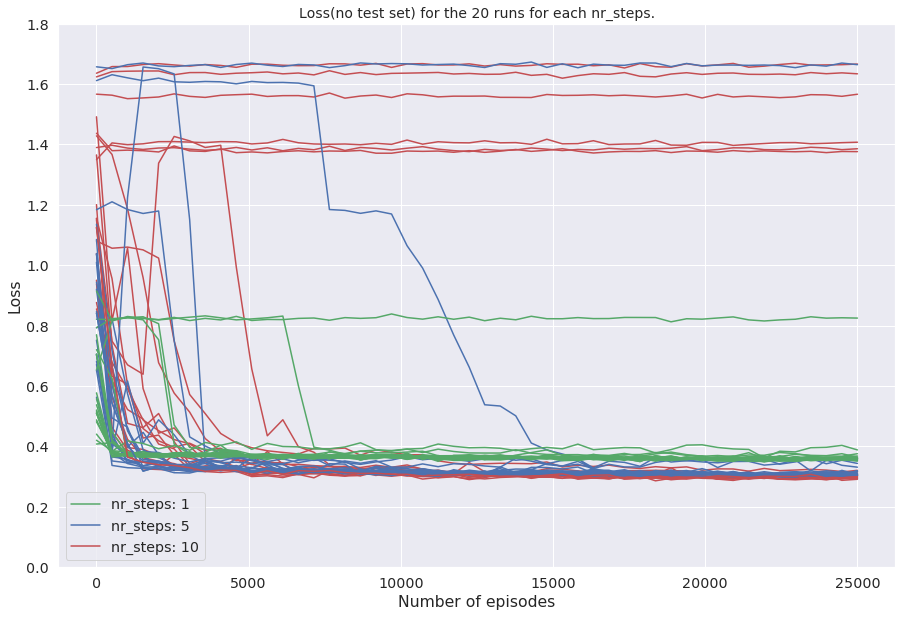

In [40]:
plt.plot(np.linspace(0, 25000, 50),data_100[9].T, color="r")
plt.plot(np.linspace(0, 25000, 50),data_100[4].T, color="b")
plt.plot(np.linspace(0, 25000, 50),data_100[0].T, color="g")
plt.plot(np.linspace(0, 25000, 50),data_100[0,0], color="g", label="nr_steps: 1")
plt.plot(np.linspace(0, 25000, 50),data_100[4,0], color="b", label="nr_steps: 5")
plt.plot(np.linspace(0, 25000, 50),data_100[9,0], color="r", label="nr_steps: 10")
plt.xlabel("Number of episodes")
plt.ylabel("Loss")
plt.ylim((0, 1.8))
plt.legend()
plt.title("Loss(no test set) for the 20 runs for each nr_steps.", fontsize=14)
plt.savefig("losses_20_data_100.png")

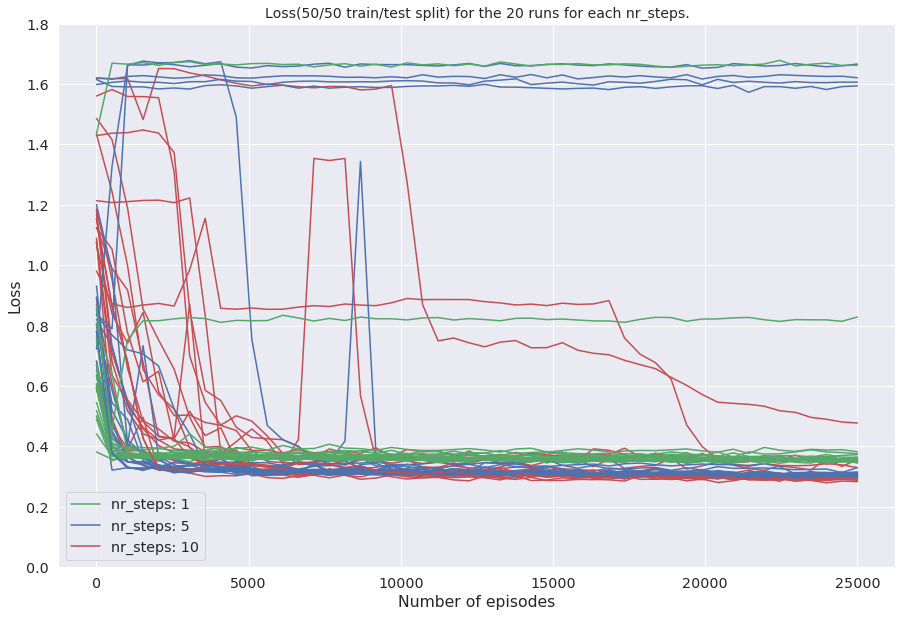

In [41]:
plt.plot(np.linspace(0, 25000, 50),data_50_50[9].T, color="r")
plt.plot(np.linspace(0, 25000, 50),data_50_50[4].T, color="b")
plt.plot(np.linspace(0, 25000, 50),data_50_50[0].T, color="g")
plt.plot(np.linspace(0, 25000, 50),data_50_50[0,0], color="g", label="nr_steps: 1")
plt.plot(np.linspace(0, 25000, 50),data_50_50[4,0], color="b", label="nr_steps: 5")
plt.plot(np.linspace(0, 25000, 50),data_50_50[9,0], color="r", label="nr_steps: 10")
plt.xlabel("Number of episodes")
plt.ylabel("Loss")
plt.ylim((0, 1.8))
plt.legend()
plt.title("Loss(50/50 train/test split) for the 20 runs for each nr_steps.", fontsize=14)
plt.savefig("losses_20_data_50_50.png")